In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# 🔵 **Dependencies**

In [ ]:
!pip install torchmetrics

# 🔵 **Before You Start**

In [3]:
!nvidia-smi

Thu Jun 20 14:23:43 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   47C    P8              10W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [ ]:
!unzip /content/drive/MyDrive/CCTV.zip

# 🔵 **Imports**

In [5]:
import torch
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader

import torchvision
from torchvision import transforms as tr
from torchvision import models

import torchmetrics as tm

import albumentations as A

from sklearn.model_selection import train_test_split
from scipy import io
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle

import json

from tqdm import tqdm

from PIL import Image

import cv2

import os
import random

In [6]:
print('torch version: ', torch.__version__)
print('torchvision version: ', torchvision.__version__)
print('numpy version: ', np.__version__)
print('pandas version: ', pd.__version__)
print('opencv version: ', cv2.__version__)
print('albumentation version: ', A.__version__)
print('torchmetrics version: ', tm.__version__)

torch version:  2.3.0+cu121
torchvision version:  0.18.0+cu121
numpy version:  1.25.2
pandas version:  2.0.3
opencv version:  4.8.0
albumentation version:  1.3.1
torchmetrics version:  1.4.0.post0


# 🔵 **Utils**

In [7]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [8]:
class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

In [9]:
def num_trainable_params(model):
  nums = sum(p.numel() for p in model.parameters() if p.requires_grad)/1e6
  return nums

In [10]:
def set_seed(seed):
  np.random.seed(seed)
  torch.manual_seed(seed)
  if torch.cuda.is_available():
      torch.cuda.manual_seed(seed)

In [11]:
class SaveChange():
  def __init__(self, saved_file_path = None):
    self.file_name = 'SaveChange.pt'
    if saved_file_path:
      self.file = torch.load(saved_file_path)
      torch.save(self.file, self.file_name)
    else:
      self.file = {}
      try:
        torch.load(self.file_name)
        print('SaveChange file exist! Are you sure you want to replace this file?[y/n]')
        n = input()
        if n == 'y':
          torch.save(self.file, self.file_name)
        else:
          self.file = torch.load(self.file_name)
      except:
        torch.save(self.file, self.file_name)

  def save(self, file, name):
    try:
      if torch.load(self.file_name)[name] == file:
        None
    except:
      self.file = torch.load(self.file_name)
      self.file[name] = file
      torch.save(self.file, self.file_name)

  def update(self, value, name):
    self.file = torch.load(self.file_name)
    self.file[name].append(value)
    torch.save(self.file, self.file_name)
  def reset(self):
    torch.save({}, self.file_name)
  def show(self):
    file = torch.load(self.file_name)
    for k in file:
      print(f'{k}:', file[k])

# 🔵 **Dataset**

## 🔵 **Look samples**

In [12]:
image = Image.open('/content/Images/CCTV_103.png').convert('RGB')
tr.functional.to_tensor(image).shape

torch.Size([3, 720, 1280])

In [13]:
images_name = os.listdir('/content/Images/')
len(images_name)

700

In [14]:
images_ann = json.load(open('/content/CCTVAnnotations.json'))['images']
annotation = json.load(open('/content/CCTVAnnotations.json'))['annotations']
categories = json.load(open('/content/CCTVAnnotations.json'))['categories']
len(images_ann), len(annotation)

(700, 933)

In [15]:
images_ann = pd.DataFrame(images_ann)
images_ann

id     file_name  height  width  license
0      1    CCTV_1.png     720   1280        1
1      2    CCTV_2.png     288    384        1
2      3    CCTV_3.png    1080   1920        1
3      4    CCTV_4.png     480    854        1
4      5    CCTV_5.png     425    634        1
..   ...           ...     ...    ...      ...
695  696  CCTV_696.png     720   1280        1
696  697  CCTV_697.png     720   1280        1
697  698  CCTV_698.png     480    704        1
698  699  CCTV_699.png     360    480        1
699  700  CCTV_700.png     720   1280        1

[700 rows x 5 columns]

In [16]:
annotation = pd.DataFrame(annotation)
annotation

id  image_id  iscrowd                              bbox    area  \
0      1         1        0  [617.18, 101.71, 119.27, 226.78]   27048   
1      2         2        0     [188.63, 136.61, 44.31, 29.9]    1324   
2      3         3        0   [1370.66, 255.98, 35.09, 91.16]    3198   
3      4         3        0     [9.91, 81.62, 1329.1, 218.45]  290341   
4      5         4        0   [130.37, 162.24, 44.98, 106.72]    4800   
..   ...       ...      ...                               ...     ...   
928  929       696        0     [184.93, 78.3, 97.56, 218.27]   21294   
929  930       697        0   [272.04, 226.98, 54.56, 133.95]    7308   
930  931       698        0     [187.72, 143.88, 64.4, 72.05]    4640   
931  932       699        0    [232.53, 52.82, 66.41, 128.02]    8501   
932  933       700        0  [916.35, 192.13, 108.58, 228.18]   24775   

     num_keypoints                                          keypoints  \
0               13  [623.08, 115.95, 2, 624.5, 108.02, 2, 0, 0, 0,...   
1               17  [204.43, 140.91, 2, 204.08, 139.46, 2, 202.74,...   
2               17  [1394.21, 260.05, 2, 1395.92, 257.5, 2, 1392.5...   
3               16  [1334.58, 209.97, 2, 0, 0, 0, 1330.69, 208.99,...   
4               15  [135.51, 165.24, 2, 136.44, 162.24, 2, 0, 0, 0...   
..             ...                                                ...   
928             16  [233.39, 86.74, 2, 234.53, 78.3, 2, 225.3, 81....   
929             11  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...   
930             11  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...   
931             14  [285.09, 54.86, 2, 287.99, 52.82, 2, 0, 0, 0, ...   
932             15  [989.21, 199.91, 2, 996.74, 192.86, 2, 988.73,...   

     category_id  
0              1  
1              1  
2              1  
3              1  
4              1  
..           ...  
928            1  
929            1  
930            1  
931            1  
932            1  

[933 rows x 8 columns]

In [17]:
annotation[annotation['image_id'] == 3]

id  image_id  iscrowd                             bbox    area  \
2   3         3        0  [1370.66, 255.98, 35.09, 91.16]    3198   
3   4         3        0    [9.91, 81.62, 1329.1, 218.45]  290341   

   num_keypoints                                          keypoints  \
2             17  [1394.21, 260.05, 2, 1395.92, 257.5, 2, 1392.5...   
3             16  [1334.58, 209.97, 2, 0, 0, 0, 1330.69, 208.99,...   

   category_id  
2            1  
3            1

In [18]:
images_name = []
for id in annotation['image_id']:
  images_name.append(images_ann[images_ann['id'] == id]['file_name'].values[0])

In [19]:
annotation['file_name'] = images_name

In [20]:
annotation

id  image_id  iscrowd                              bbox    area  \
0      1         1        0  [617.18, 101.71, 119.27, 226.78]   27048   
1      2         2        0     [188.63, 136.61, 44.31, 29.9]    1324   
2      3         3        0   [1370.66, 255.98, 35.09, 91.16]    3198   
3      4         3        0     [9.91, 81.62, 1329.1, 218.45]  290341   
4      5         4        0   [130.37, 162.24, 44.98, 106.72]    4800   
..   ...       ...      ...                               ...     ...   
928  929       696        0     [184.93, 78.3, 97.56, 218.27]   21294   
929  930       697        0   [272.04, 226.98, 54.56, 133.95]    7308   
930  931       698        0     [187.72, 143.88, 64.4, 72.05]    4640   
931  932       699        0    [232.53, 52.82, 66.41, 128.02]    8501   
932  933       700        0  [916.35, 192.13, 108.58, 228.18]   24775   

     num_keypoints                                          keypoints  \
0               13  [623.08, 115.95, 2, 624.5, 108.02, 2, 0, 0, 0,...   
1               17  [204.43, 140.91, 2, 204.08, 139.46, 2, 202.74,...   
2               17  [1394.21, 260.05, 2, 1395.92, 257.5, 2, 1392.5...   
3               16  [1334.58, 209.97, 2, 0, 0, 0, 1330.69, 208.99,...   
4               15  [135.51, 165.24, 2, 136.44, 162.24, 2, 0, 0, 0...   
..             ...                                                ...   
928             16  [233.39, 86.74, 2, 234.53, 78.3, 2, 225.3, 81....   
929             11  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...   
930             11  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...   
931             14  [285.09, 54.86, 2, 287.99, 52.82, 2, 0, 0, 0, ...   
932             15  [989.21, 199.91, 2, 996.74, 192.86, 2, 988.73,...   

     category_id     file_name  
0              1    CCTV_1.png  
1              1    CCTV_2.png  
2              1    CCTV_3.png  
3              1    CCTV_3.png  
4              1    CCTV_4.png  
..           ...           ...  
928            1  CCTV_696.png  
929            1  CCTV_697.png  
930            1  CCTV_698.png  
931            1  CCTV_699.png  
932            1  CCTV_700.png  

[933 rows x 9 columns]

In [21]:
def show_random_joints_on_image(annotation, data_dir, number):
  images_name = np.unique(np.array(annotation['file_name'].values))
  r = random.sample(range(0, len(images_name)), number)
  plt.figure(figsize = (20, 20 ))
  plt.subplot(int(np.sqrt(number)) + 1, int(np.sqrt(number)) + 1, 1)
  id = images_name[r[0]]
  joints = np.array([j for j in annotation[annotation['file_name'] == id]['keypoints'].values]).tolist()
  boxs = np.array([k for k in annotation[annotation['file_name'] == id]['bbox'].values]).tolist()
  def plot(id, joints, boxs):
    for i in range(len(boxs)):
      joint = np.array(joints[i])
      box = boxs[i]

      x = joint[0::3]
      y = joint[1::3]
      v = joint[2::3]
      im = Image.open(f'{data_dir}/{id}').convert('RGB')
      plt.imshow(im)
      plt.scatter(x, y)
      ax = plt.gca()
      rect =  Rectangle((box[0], box[1]),
                        (box[2]),
                        (box[3]),
                        fill = False,
                        edgecolor = (1, 0, 0),
                        linewidth = 2)
      ax.add_patch(rect)

  plot(id, joints, boxs)
  plt.axis('off')
  for i in range(number - 1):
    plt.subplot(int(np.sqrt(number)) + 1, int(np.sqrt(number)) + 1 , i+2)
    id = images_name[r[i+1]]
    joints = np.array([j for j in annotation[annotation['file_name'] == id]['keypoints'].values]).tolist()
    boxs = np.array([k for k in annotation[annotation['file_name'] == id]['bbox'].values]).tolist()
    plot(id, joints, boxs)
    plt.axis('off')
  plt.show()

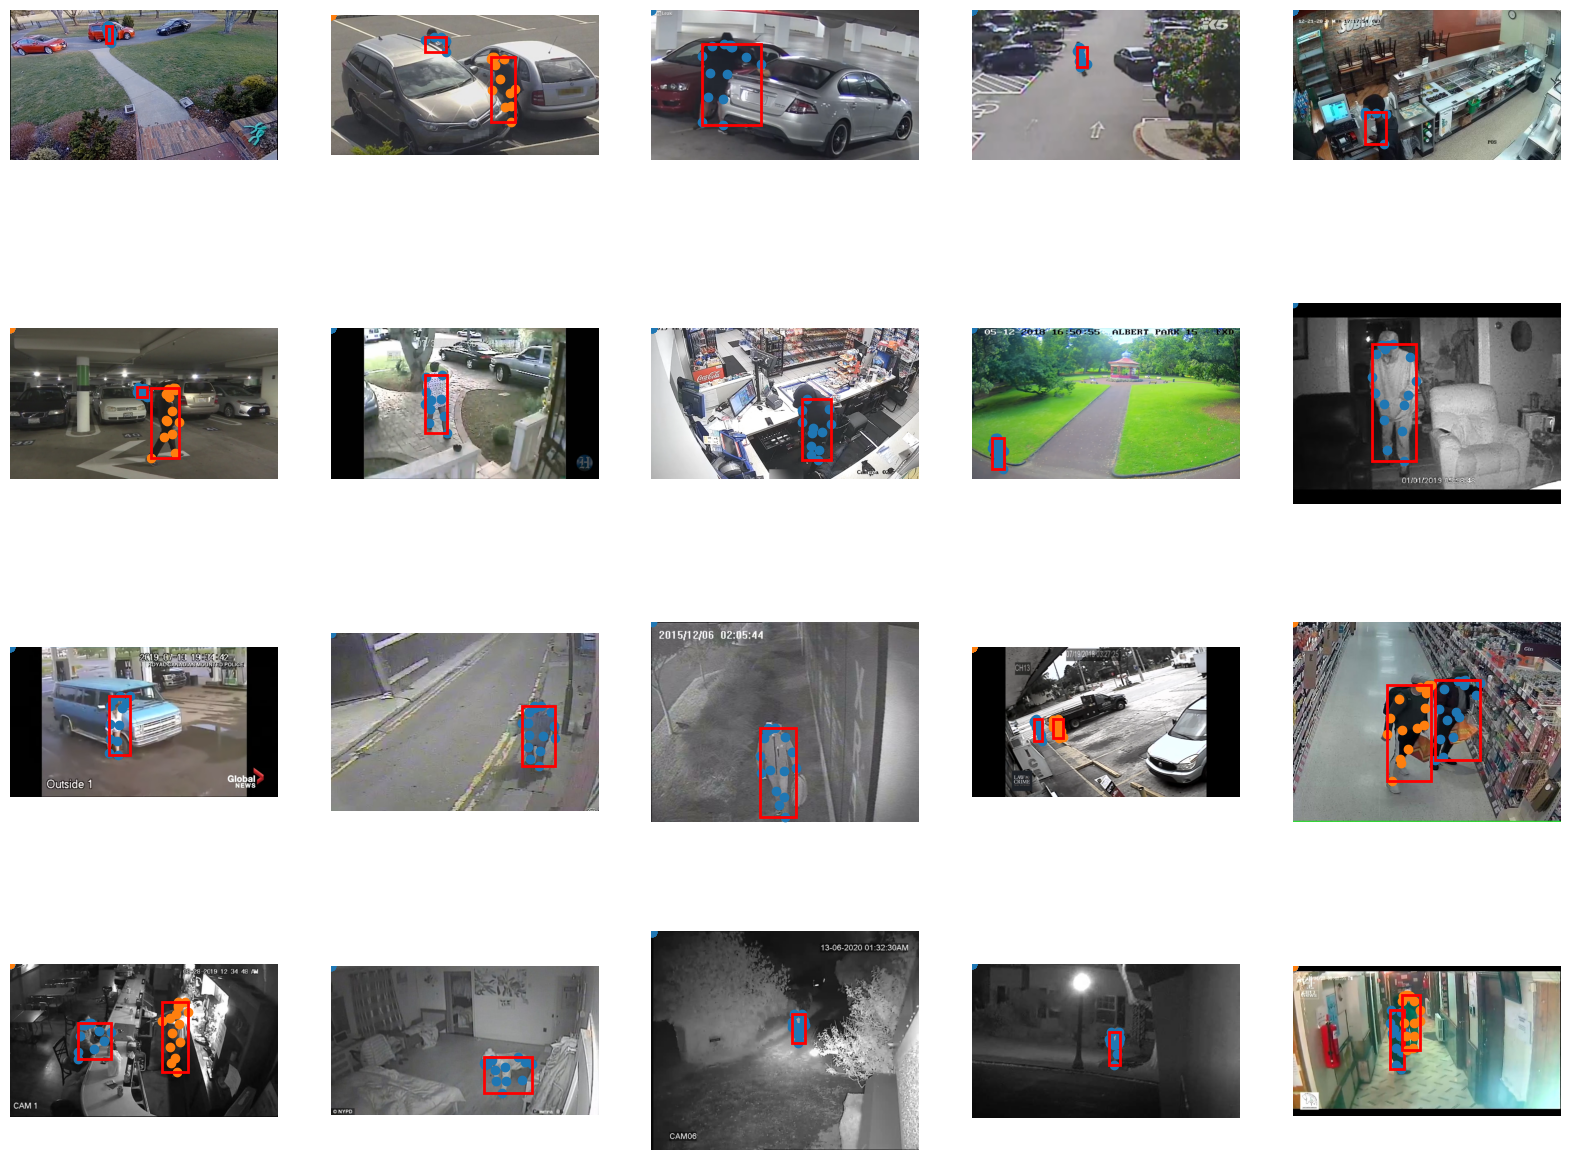

In [22]:
show_random_joints_on_image(annotation, '/content/Images', 20)

## 🔵 **Split**

In [23]:
images_name = np.array(np.unique(annotation['file_name'].tolist()))
images_name.shape

(700,)

In [24]:
train_im, valid_im = train_test_split(images_name, test_size = 0.3, random_state = 42)
valid_im, test_im  = train_test_split(valid_im, test_size = 0.5, random_state = 42)
train_im.shape, valid_im.shape, test_im.shape

((490,), (105,), (105,))

In [25]:
def change(file):
  new = []
  for id in file:
    [new.append(v) for v in annotation[annotation['file_name'] == id].values.tolist()]

  return pd.DataFrame(new, columns = annotation.columns)
train_df = change(train_im)
valid_df = change(valid_im)
test_df  = change(test_im)
train_df.shape, valid_df.shape, test_df.shape

((642, 9), (151, 9), (140, 9))

In [26]:
train_df[train_df['file_name'] == 'CCTV_294.png']['bbox'].values[0][3] = 352.5
train_df[train_df['file_name'] == 'CCTV_501.png']['bbox'].values[0][3] = 464.2
valid_df[valid_df['file_name'] == 'CCTV_241.png']['bbox'].values[0][3] = 372

In [27]:
train_df.to_csv('train_df.csv')
valid_df.to_csv('valid_df.csv')
test_df.to_csv('test_df.csv')

## 🔵 **EDA**

In [28]:
mean = 0
std = 0
for i, name in enumerate(train_im):
  im = tr.functional.to_tensor(Image.open(f'/content/Images/{name}').convert('RGB'))
  mean += im.mean(dim = [1, 2])
  std += im.std(dim = [1, 2])
print(f'mean : {mean/(i+1)}')
print(f'std  : {std/(i+1)}')

mean : tensor([0.4265, 0.4245, 0.4144])
std  : tensor([0.2198, 0.2197, 0.2214])


## 🔵 **Custom Dataset**

In [29]:
class LSPDataset(Dataset):
  def __init__(self, data_dir, df, transform = None):
    self.df = df
    self.data_dir = data_dir
    self.images_name = np.unique(np.array(self.df['file_name'].values.tolist())).tolist()
    self.class_labels =  ["nose","left eye","right eye","left ear","right ear","left shoulder","right shoulder","left elbow","right elbow",
                          "left wrist","right wrist","left hip","right hip",
                          "left knee","right knee","left ankle","right ankle"]

    self.connect_law = ['left eye-right eye', 'left elbow-left wrist', 'right elbow-right wrist', 'left shoulder-left elbow', 'right shoulder-right elbow',
                        'right shoulder-right hip', 'left shoulder-left hip', 'right knee-right ankle', 'left knee-left ankle', 'left knee-left hip',
                        'right knee-right hip','left hip-right hip', 'right shoulder-left shoulder', 'nose-left eye', 'nose-right eye', 'left eye-left ear',
                        'right eye-right ear', 'left ear-left shoulder']

    colors = [(236, 141, 141), (47, 0, 11), (113, 0, 11), (232, 0, 11), (43, 69, 11), (163, 69, 11), (7, 115, 11), (252, 168, 11), (252, 209, 11),
              (252, 209, 111), (252, 209, 152), (252, 209, 198), (2, 141, 141), (165, 141, 141), (165, 141, 251), (0, 141, 141), (165, 23, 141), (165, 250, 141)]

    self.colors = [[x/255 for x in y] for y in colors]

    self.connection_color = self.colors

    self.transform = transform

  def __getitem__(self, index):
    path = self.images_name[index]
    image = cv2.imread(self.data_dir + path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    anno  = self.df[self.df['file_name'] == path]
    joints = np.array(anno['keypoints'].values.tolist())

    x = joints[:, 0::3]
    x = x.reshape(x.shape[0], x.shape[1], 1)
    y = joints[:, 1::3]
    y = y.reshape(y.shape[0], y.shape[1], 1)
    v = joints[:, 2::3]
    v = v.reshape(v.shape[0], v.shape[1], 1)
    joints = np.concatenate([x, y, v], axis = 2)
    boxes  = np.array([k for k in anno['bbox'].values.tolist()])
    boxes  = np.concatenate([boxes, np.ones((boxes.shape[0], 1))], axis = 1)

    if self.transform :
      transformed = self.transform(image)
      image_tensor = torch.tensor(transformed['image']/255).permute(2, 0, 1).float()
      joint = torch.tensor(transformed['keypoints']).float()
      labels = transformed['class_labels']
    else:
      transformed = A.Compose([],
                             keypoint_params=A.KeypointParams(format='xy', remove_invisible=False),
                              bbox_params = A.BboxParams(format = ('coco')))(image = image,keypoints = joints, bboxes = boxes)

      image_tensor = torch.tensor(transformed['image']/255).permute(2, 0, 1).float()
      bboxes = torch.tensor(transformed['bboxes'])
      joint = torch.tensor(transformed['keypoints']).float()

    target = {}
    target['boxes'] = torch.tensor(bboxes.tolist()).float()[:, :4]
    target['boxes'][:, 2] = target['boxes'][:, 0] + target['boxes'][:, 2]
    target['boxes'][:, 3] = target['boxes'][:, 1] + target['boxes'][:, 3]
    target['keypoints'] = torch.tensor(joint.tolist()).float()
    target['labels'] = torch.ones((bboxes.shape[0]), dtype = torch.long)


    return image_tensor, target

  def __len__(self):
    return len(self.images_name)

In [30]:
train_dataset = LSPDataset('/content/Images/', train_df)
valid_dataset = LSPDataset('/content/Images/', valid_df)
test_dataset = LSPDataset('/content/Images/', test_df)
len(train_dataset), len(valid_dataset), len(test_dataset)

(490, 105, 105)

In [31]:
len(train_dataset.class_labels), len(train_dataset.connect_law), len(train_dataset.connection_color), len(train_dataset.colors)

(17, 18, 18, 18)

In [32]:
image, target = train_dataset[0]
image.shape, target['keypoints'].shape, target['boxes'].shape, target['labels'].shape

<ipython-input-29-a0487bca0d42>:53: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:274.)
  joint = torch.tensor(transformed['keypoints']).float()


(torch.Size([3, 720, 1280]),
 torch.Size([1, 17, 3]),
 torch.Size([1, 4]),
 torch.Size([1]))

## 🔵 **Visualize**

In [33]:
def show_random_samples(dataset, number):
  r = random.sample(range(0, len(dataset)), number)
  plt.figure(figsize = (20, 20 ))
  plt.subplot(int(np.sqrt(number)) + 1, int(np.sqrt(number)) + 1, 1)
  all_key_name = dataset.class_labels
  connection_rule = dataset.connect_law
  colors_list = dataset.colors
  connection_color = dataset.connection_color
  im, j0 = dataset[r[0]]
  def plot_one(im, j0):
    for i in range(j0['boxes'].shape[0]):
      j1 = j0['keypoints'].numpy()[i]
      box = j0['boxes'].tolist()[i]
      key_name = []
      j = []
      for k in range(j1.shape[0]):
        if j1[k][2]>0:
          j.append(j1[k])
          key_name.append(all_key_name[k])

      j = np.array(j)


      ax = plt.gca()
      rect = Rectangle((box[0], box[1]),
                       (box[2] - box[0]),
                       (box[3] - box[1]),
                        fill = False,
                        edgecolor = (1, 0, 0),
                        linewidth = 2)
      ax.add_patch(rect)
      plt.imshow(im.permute(1, 2, 0).numpy())
      for key in key_name:
        plt.scatter(j[key_name.index(key), 0], j[key_name.index(key), 1], c = colors_list[all_key_name.index(key)])

      for i, connection in enumerate(connection_rule):
        a, b = connection.split('-')
        if a in key_name and b in key_name:
          plt.plot([j[key_name.index(a), 0], j[key_name.index(b), 0]], [j[key_name.index(a), 1], j[key_name.index(b), 1]], color = connection_color[i])

  plot_one(im, j0)

  plt.axis('off')
  for i in range(number - 1):
    plt.subplot(int(np.sqrt(number)) + 1, int(np.sqrt(number)) + 1, i + 2)
    im, j0 = dataset[r[i + 1]]
    plot_one(im, j0)
    plt.axis('off')
  plt.show()

<ipython-input-33-83f620319f58>:34: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  plt.scatter(j[key_name.index(key), 0], j[key_name.index(key), 1], c = colors_list[all_key_name.index(key)])


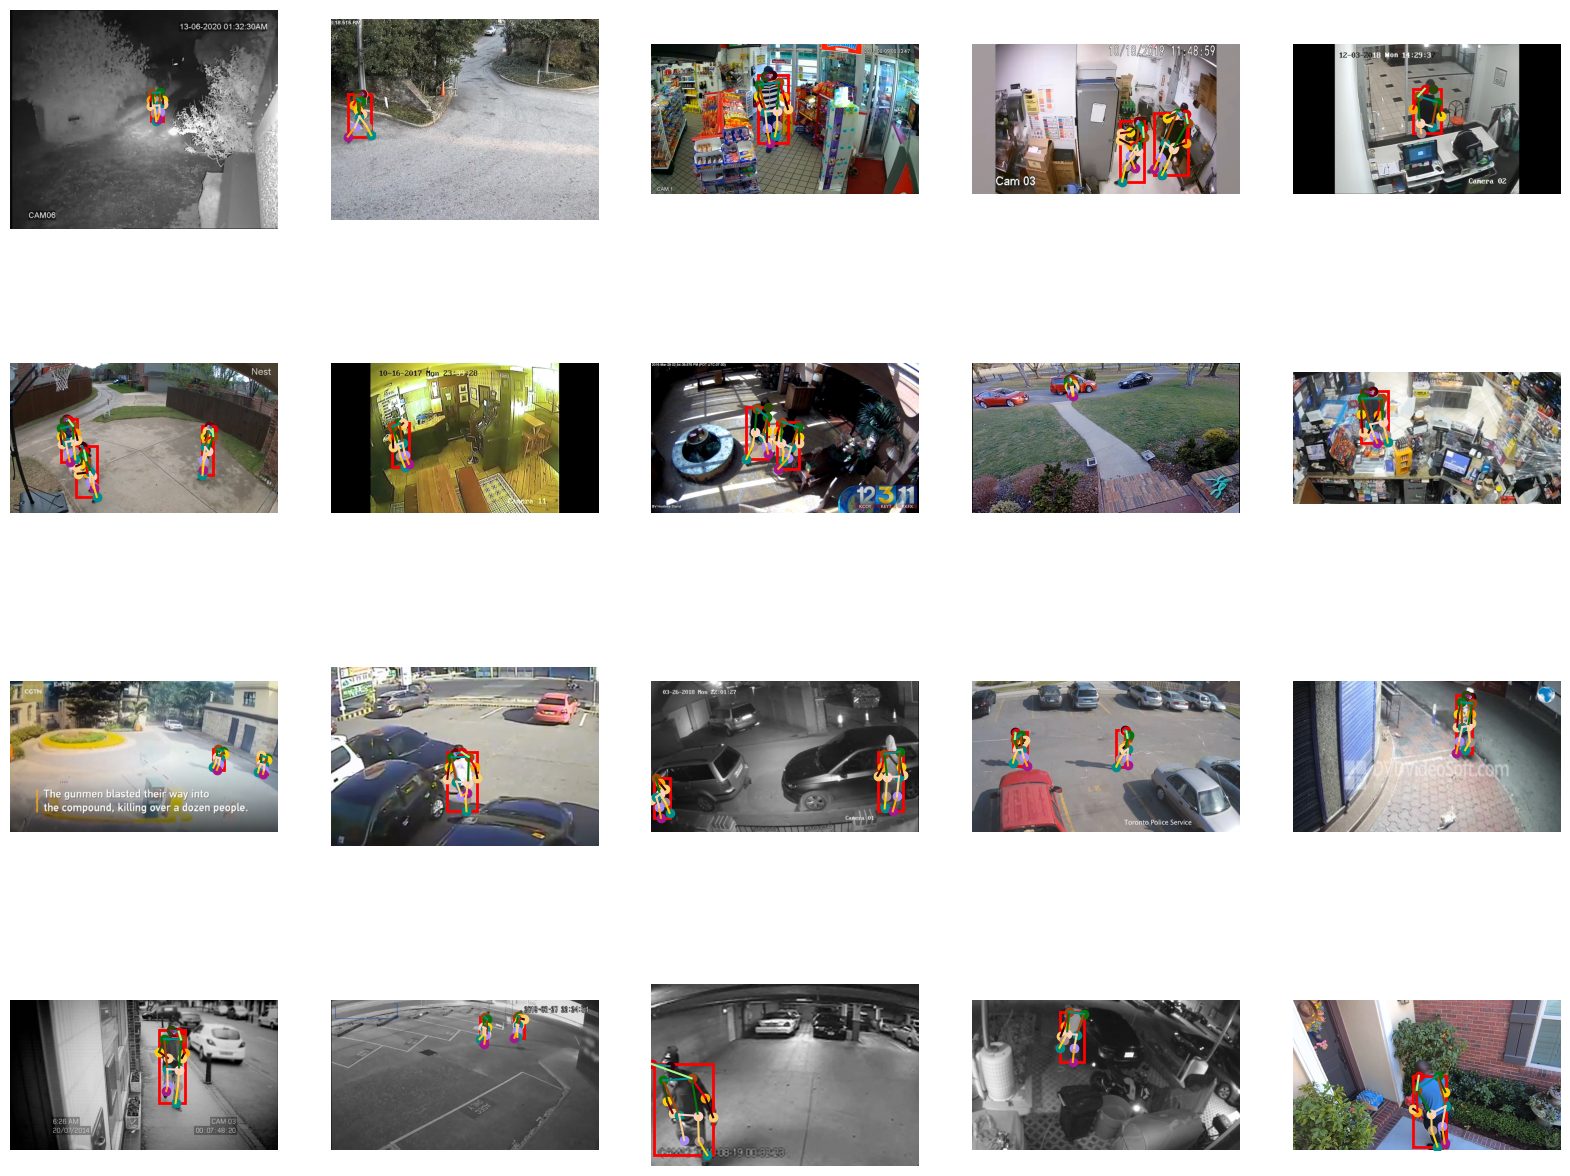

In [34]:
show_random_samples(train_dataset, 20)

## 🔵 **DataLoader**

In [35]:
def collate(batch):
  return tuple(zip(*batch))

In [36]:
train_loader = DataLoader(train_dataset, batch_size = 2, shuffle = True, collate_fn = collate)
valid_loader = DataLoader(valid_dataset, batch_size = 2, shuffle = False, collate_fn = collate)
test_loader  = DataLoader(test_dataset, batch_size = 2, shuffle = False, collate_fn = collate)

In [37]:
x, y = next(iter(train_loader))

In [38]:
x[0].shape, y[0]['keypoints'].shape

(torch.Size([3, 720, 1280]), torch.Size([1, 17, 3]))

# 🔵 **Model**

In [39]:
class KeypointRCNN(nn.Module):
  def __init__(self):
    super(KeypointRCNN, self).__init__()
    self.model = models.detection.keypointrcnn_resnet50_fpn()

  def forward(self, images, targets = None):
    if self.train:
      y = self.model(images, targets)
    else:
      y = self.model(images)
    return y

In [40]:
model = KeypointRCNN().to(device)

Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:01<00:00, 93.1MB/s]


In [41]:
num_trainable_params(model)

58.914858

In [42]:
imgs, kps = next(iter(train_loader))
img = imgs[0]
kp = kps[0]
img.shape, kp['keypoints'].shape

(torch.Size([3, 720, 1280]), torch.Size([2, 17, 3]))

In [43]:
model = model.eval()

In [44]:
images  = [image.to(device) for image in imgs]
targets = [{k: v.to(device) for k, v in t.items()} for t in kps]

In [45]:
out = model(images, targets)

In [ ]:
out

In [47]:
out[0]['keypoints'].shape

torch.Size([100, 17, 3])

In [48]:
out[0]['keypoints_scores'].shape

torch.Size([100, 17])

# 🔵 **Training on Custom dataset**

## 🔵 **Train One Epoch**

In [49]:
def train_one_epoch(model, train_loader, loss_func, optimizer, shedular, epoch):
    model.train()
    train_loss=AverageMeter()
    keypoint_loss = AverageMeter()

    with tqdm(train_loader, unit='batch') as tepoch:
        for idx, (images, targets) in enumerate(tepoch):
            if epoch is not None:
                tepoch.set_description(f'Epoch={epoch}')

            optimizer.zero_grad()

            images  = [image.to(device) for image in images]
            targets = [{k: v.to(device) for k, v in t.items()} for t in targets]


            loss_dict = model(images, targets)
            loss      = sum(error for error in loss_dict.values())

            loss.backward()
            optimizer.step()
            if shedular:
                shedular.step()

            train_loss.update(loss.item())
            keypoint_loss.update(loss_dict['loss_keypoint'].item())


            tepoch.set_postfix(total_loss=train_loss.avg, keypoints_loss = keypoint_loss.avg)

    return model, train_loss.avg, keypoint_loss.avg

## 🔵 **Evaluate**

In [50]:
def validation(model, valid_loaedr, loss_func, device):
    model.eval()
    model = model.to(device)

    map = tm.detection.MeanAveragePrecision('xyxy')

    for batch in valid_loaedr:

        images  = [image.to(device) for image in batch[0]]
        targets = [{k: v.to(device) for k, v in t.items()} for t in batch[1]]

        with torch.no_grad():
          pred = model(images)


        map.update(pred, targets)

    print('========================================================================================')
    print(f"|| mAP               = {map.compute()['map']:0.2}      ||    mAP|50     = {map.compute()['map_50']:0.2}    ||   mAP|75    ={ map.compute()['map_75']:0.2}  ||")
    print('========================================================================================')
    print(f"|| mAP|small         = {map.compute()['map_small']:0.2}      ||    mAP|medium = {map.compute()['map_medium']:0.2}    ||   mAP|large = {map.compute()['map_large']:0.2} ||")
    print('========================================================================================')
    print(f"|| mAR|1             = {map.compute()['mar_1']:0.2}      ||    mAR|10     = {map.compute()['mar_10']:0.2}    ||   mAR|100   = {map.compute()['mar_100']:0.2} ||")
    print('========================================================================================')
    print(f"|| mAR|small         = {map.compute()['mar_small']:0.2}      ||    mAR|medium = {map.compute()['mar_medium']:0.2}    ||   mAR|large = {map.compute()['mar_large']:0.2} ||")
    print('========================================================================================')
    print(f"|| mAP|per_class     = {map.compute()['map_per_class']:0.2}      ||                         ||                    ||")
    print('========================================================================================')
    print(f"|| mAR|100_per_class = {map.compute()['mar_100_per_class']:0.2}      ||                         ||                    ||")
    print('========================================================================================')


    return map.compute()['map'].item()

## 🔵 **Training Process**

In [ ]:
torch.cuda.empty_cache()

In [51]:
set_seed(42)
model = KeypointRCNN().to(device)
num_trainable_params(model)

58.914858

In [52]:
model = torch.load('/content/drive/MyDrive/last_model.pt').to(device)
num_trainable_params(model)

58.914858

In [53]:
set_seed(42)
train_loader = DataLoader(train_dataset, batch_size = 2, shuffle = True, num_workers = 2, collate_fn = collate)

In [54]:
train_loss_hist, keypoint_loss_hist = [], []
valid_map_hist = []
best_map   = 0
sc = SaveChange()
sc.save(train_loss_hist, 'train_loss_hist')
sc.save(keypoint_loss_hist, 'keypoint_loss_hist')
sc.save(keypoint_loss_hist, 'valid_map_hist')
sc.save([0], 'best_map')
sc.show()

SaveChange file exist! Are you sure you want to replace this file?[y/n]
n
train_loss_hist: [7.907313115256173, 7.739366035072171, 7.5971036891548005, 7.494907778136584, 7.3081327632981905, 7.123019759509028, 6.947624603582888, 6.630017650370696, 6.408308507958237, 6.212533758124526, 6.062999279645025, 5.902587398217649, 5.724557191498426, 5.635731481046093, 5.50914761387572, 5.389769974533392, 5.3047236462028655, 5.190185914720808, 5.08627725620659, 4.952661512335952, 4.89370020944245, 4.8305328592962145, 4.670054622572295, 4.591808485498234, 4.443962840644681, 4.342700581647912, 4.435746286353287, 4.409604597091675, 4.136304548808506, 4.090753040508348, 3.970468247666651, 3.838037112294411, 3.70779434320878, 3.737029754872225, 3.6065352692896004, 3.461469166619437, 3.3499237556846775, 3.2765732716540903, 3.205088236867165, 3.1888091856119583, 2.957632567931195, 2.64482258825886, 2.4358936285486026, 2.318364014430922, 2.2213028187654458, 2.1026517391204833, 2.0443033714683687, 1.983525

In [55]:
optimizer = optim.SGD(model.parameters(), lr = 0.0007, momentum = 0.9, weight_decay = 1e-5)
shedular  = optim.lr_scheduler.LinearLR(optimizer, 1/1000, total_iters= 350)

In [57]:
set_seed(42)

start, stop = 70, 100
wait = 0

for i in range(start, stop):

  model, train_loss, keypoint_loss = train_one_epoch(model, train_loader, None,  optimizer, shedular, i)
  valid_map = validation(model, valid_loader, None, device)

  train_loss_hist.append(train_loss)
  sc.update(train_loss, 'train_loss_hist')
  keypoint_loss_hist.append(keypoint_loss)
  sc.update(keypoint_loss, 'keypoint_loss_hist')
  valid_map_hist.append(valid_map)
  sc.update(valid_map, 'valid_map_hist')

  if valid_map>best_map:

    torch.save(model, 'best_model.pt')
    print('model saved!')
    best_map = valid_map
    sc.update(best_map, 'best_map')

Epoch=70:   0%|          | 0/245 [00:00<?, ?batch/s]/usr/local/lib/python3.10/dist-packages/torch/autograd/graph.py:744: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
Epoch=70: 100%|██████████| 245/245 [02:47<00:00,  1.46batch/s, keypoints_loss=1.3, total_loss=1.36]


|| mAP               = 0.35      ||    mAP|50     = 0.72    ||   mAP|75    =0.29  ||
|| mAP|small         = 0.31      ||    mAP|medium = 0.35    ||   mAP|large = 0.36 ||
|| mAR|1             = 0.32      ||    mAR|10     = 0.43    ||   mAR|100   = 0.43 ||
|| mAR|small         = 0.39      ||    mAR|medium = 0.42    ||   mAR|large = 0.45 ||
|| mAP|per_class     = -1.0      ||                         ||                    ||
|| mAR|100_per_class = -1.0      ||                         ||                    ||
model saved!


Epoch=71: 100%|██████████| 245/245 [02:52<00:00,  1.42batch/s, keypoints_loss=1.24, total_loss=1.31]


|| mAP               = 0.34      ||    mAP|50     = 0.72    ||   mAP|75    =0.27  ||
|| mAP|small         = 0.3      ||    mAP|medium = 0.33    ||   mAP|large = 0.36 ||
|| mAR|1             = 0.32      ||    mAR|10     = 0.42    ||   mAR|100   = 0.42 ||
|| mAR|small         = 0.36      ||    mAR|medium = 0.39    ||   mAR|large = 0.44 ||
|| mAP|per_class     = -1.0      ||                         ||                    ||
|| mAR|100_per_class = -1.0      ||                         ||                    ||


Epoch=72: 100%|██████████| 245/245 [02:52<00:00,  1.42batch/s, keypoints_loss=1.24, total_loss=1.31]


|| mAP               = 0.35      ||    mAP|50     = 0.72    ||   mAP|75    =0.29  ||
|| mAP|small         = 0.31      ||    mAP|medium = 0.35    ||   mAP|large = 0.36 ||
|| mAR|1             = 0.32      ||    mAR|10     = 0.43    ||   mAR|100   = 0.43 ||
|| mAR|small         = 0.36      ||    mAR|medium = 0.42    ||   mAR|large = 0.44 ||
|| mAP|per_class     = -1.0      ||                         ||                    ||
|| mAR|100_per_class = -1.0      ||                         ||                    ||
model saved!


Epoch=73: 100%|██████████| 245/245 [02:52<00:00,  1.42batch/s, keypoints_loss=1.22, total_loss=1.29]


|| mAP               = 0.36      ||    mAP|50     = 0.72    ||   mAP|75    =0.31  ||
|| mAP|small         = 0.28      ||    mAP|medium = 0.35    ||   mAP|large = 0.38 ||
|| mAR|1             = 0.34      ||    mAR|10     = 0.44    ||   mAR|100   = 0.44 ||
|| mAR|small         = 0.28      ||    mAR|medium = 0.42    ||   mAR|large = 0.47 ||
|| mAP|per_class     = -1.0      ||                         ||                    ||
|| mAR|100_per_class = -1.0      ||                         ||                    ||
model saved!


Epoch=74: 100%|██████████| 245/245 [02:51<00:00,  1.43batch/s, keypoints_loss=1.21, total_loss=1.27]


|| mAP               = 0.35      ||    mAP|50     = 0.72    ||   mAP|75    =0.29  ||
|| mAP|small         = 0.28      ||    mAP|medium = 0.36    ||   mAP|large = 0.36 ||
|| mAR|1             = 0.32      ||    mAR|10     = 0.42    ||   mAR|100   = 0.42 ||
|| mAR|small         = 0.28      ||    mAR|medium = 0.41    ||   mAR|large = 0.44 ||
|| mAP|per_class     = -1.0      ||                         ||                    ||
|| mAR|100_per_class = -1.0      ||                         ||                    ||


Epoch=75: 100%|██████████| 245/245 [02:53<00:00,  1.41batch/s, keypoints_loss=1.17, total_loss=1.24]


|| mAP               = 0.35      ||    mAP|50     = 0.71    ||   mAP|75    =0.31  ||
|| mAP|small         = 0.28      ||    mAP|medium = 0.35    ||   mAP|large = 0.37 ||
|| mAR|1             = 0.33      ||    mAR|10     = 0.43    ||   mAR|100   = 0.43 ||
|| mAR|small         = 0.28      ||    mAR|medium = 0.42    ||   mAR|large = 0.45 ||
|| mAP|per_class     = -1.0      ||                         ||                    ||
|| mAR|100_per_class = -1.0      ||                         ||                    ||


Epoch=76: 100%|██████████| 245/245 [02:52<00:00,  1.42batch/s, keypoints_loss=1.18, total_loss=1.24]


|| mAP               = 0.35      ||    mAP|50     = 0.73    ||   mAP|75    =0.29  ||
|| mAP|small         = 0.28      ||    mAP|medium = 0.35    ||   mAP|large = 0.36 ||
|| mAR|1             = 0.32      ||    mAR|10     = 0.42    ||   mAR|100   = 0.42 ||
|| mAR|small         = 0.3      ||    mAR|medium = 0.41    ||   mAR|large = 0.44 ||
|| mAP|per_class     = -1.0      ||                         ||                    ||
|| mAR|100_per_class = -1.0      ||                         ||                    ||


Epoch=77: 100%|██████████| 245/245 [02:52<00:00,  1.42batch/s, keypoints_loss=1.16, total_loss=1.23]


|| mAP               = 0.35      ||    mAP|50     = 0.73    ||   mAP|75    =0.3  ||
|| mAP|small         = 0.31      ||    mAP|medium = 0.37    ||   mAP|large = 0.36 ||
|| mAR|1             = 0.32      ||    mAR|10     = 0.43    ||   mAR|100   = 0.43 ||
|| mAR|small         = 0.36      ||    mAR|medium = 0.43    ||   mAR|large = 0.44 ||
|| mAP|per_class     = -1.0      ||                         ||                    ||
|| mAR|100_per_class = -1.0      ||                         ||                    ||


Epoch=78: 100%|██████████| 245/245 [02:53<00:00,  1.42batch/s, keypoints_loss=1.17, total_loss=1.23]


|| mAP               = 0.35      ||    mAP|50     = 0.73    ||   mAP|75    =0.3  ||
|| mAP|small         = 0.31      ||    mAP|medium = 0.35    ||   mAP|large = 0.36 ||
|| mAR|1             = 0.32      ||    mAR|10     = 0.43    ||   mAR|100   = 0.43 ||
|| mAR|small         = 0.36      ||    mAR|medium = 0.41    ||   mAR|large = 0.44 ||
|| mAP|per_class     = -1.0      ||                         ||                    ||
|| mAR|100_per_class = -1.0      ||                         ||                    ||


Epoch=79: 100%|██████████| 245/245 [02:52<00:00,  1.42batch/s, keypoints_loss=1.14, total_loss=1.21]


|| mAP               = 0.36      ||    mAP|50     = 0.73    ||   mAP|75    =0.33  ||
|| mAP|small         = 0.28      ||    mAP|medium = 0.37    ||   mAP|large = 0.37 ||
|| mAR|1             = 0.32      ||    mAR|10     = 0.43    ||   mAR|100   = 0.43 ||
|| mAR|small         = 0.28      ||    mAR|medium = 0.43    ||   mAR|large = 0.45 ||
|| mAP|per_class     = -1.0      ||                         ||                    ||
|| mAR|100_per_class = -1.0      ||                         ||                    ||


Epoch=80: 100%|██████████| 245/245 [02:53<00:00,  1.41batch/s, keypoints_loss=1.14, total_loss=1.2]


|| mAP               = 0.35      ||    mAP|50     = 0.71    ||   mAP|75    =0.29  ||
|| mAP|small         = 0.3      ||    mAP|medium = 0.37    ||   mAP|large = 0.36 ||
|| mAR|1             = 0.32      ||    mAR|10     = 0.43    ||   mAR|100   = 0.43 ||
|| mAR|small         = 0.34      ||    mAR|medium = 0.43    ||   mAR|large = 0.44 ||
|| mAP|per_class     = -1.0      ||                         ||                    ||
|| mAR|100_per_class = -1.0      ||                         ||                    ||


Epoch=81: 100%|██████████| 245/245 [02:54<00:00,  1.40batch/s, keypoints_loss=1.13, total_loss=1.19]


|| mAP               = 0.34      ||    mAP|50     = 0.72    ||   mAP|75    =0.27  ||
|| mAP|small         = 0.31      ||    mAP|medium = 0.35    ||   mAP|large = 0.36 ||
|| mAR|1             = 0.32      ||    mAR|10     = 0.42    ||   mAR|100   = 0.42 ||
|| mAR|small         = 0.35      ||    mAR|medium = 0.4    ||   mAR|large = 0.43 ||
|| mAP|per_class     = -1.0      ||                         ||                    ||
|| mAR|100_per_class = -1.0      ||                         ||                    ||


Epoch=82: 100%|██████████| 245/245 [02:53<00:00,  1.42batch/s, keypoints_loss=1.12, total_loss=1.18]


|| mAP               = 0.34      ||    mAP|50     = 0.72    ||   mAP|75    =0.28  ||
|| mAP|small         = 0.28      ||    mAP|medium = 0.34    ||   mAP|large = 0.36 ||
|| mAR|1             = 0.32      ||    mAR|10     = 0.41    ||   mAR|100   = 0.41 ||
|| mAR|small         = 0.28      ||    mAR|medium = 0.39    ||   mAR|large = 0.44 ||
|| mAP|per_class     = -1.0      ||                         ||                    ||
|| mAR|100_per_class = -1.0      ||                         ||                    ||


Epoch=83: 100%|██████████| 245/245 [02:55<00:00,  1.39batch/s, keypoints_loss=1.12, total_loss=1.18]


|| mAP               = 0.35      ||    mAP|50     = 0.72    ||   mAP|75    =0.28  ||
|| mAP|small         = 0.31      ||    mAP|medium = 0.34    ||   mAP|large = 0.37 ||
|| mAR|1             = 0.32      ||    mAR|10     = 0.43    ||   mAR|100   = 0.43 ||
|| mAR|small         = 0.36      ||    mAR|medium = 0.4    ||   mAR|large = 0.45 ||
|| mAP|per_class     = -1.0      ||                         ||                    ||
|| mAR|100_per_class = -1.0      ||                         ||                    ||


Epoch=84: 100%|██████████| 245/245 [02:53<00:00,  1.42batch/s, keypoints_loss=1.1, total_loss=1.16]


|| mAP               = 0.35      ||    mAP|50     = 0.72    ||   mAP|75    =0.29  ||
|| mAP|small         = 0.32      ||    mAP|medium = 0.35    ||   mAP|large = 0.37 ||
|| mAR|1             = 0.32      ||    mAR|10     = 0.43    ||   mAR|100   = 0.43 ||
|| mAR|small         = 0.37      ||    mAR|medium = 0.41    ||   mAR|large = 0.44 ||
|| mAP|per_class     = -1.0      ||                         ||                    ||
|| mAR|100_per_class = -1.0      ||                         ||                    ||


Epoch=85: 100%|██████████| 245/245 [02:52<00:00,  1.42batch/s, keypoints_loss=1.11, total_loss=1.17]


|| mAP               = 0.35      ||    mAP|50     = 0.72    ||   mAP|75    =0.3  ||
|| mAP|small         = 0.31      ||    mAP|medium = 0.35    ||   mAP|large = 0.36 ||
|| mAR|1             = 0.32      ||    mAR|10     = 0.44    ||   mAR|100   = 0.44 ||
|| mAR|small         = 0.36      ||    mAR|medium = 0.42    ||   mAR|large = 0.45 ||
|| mAP|per_class     = -1.0      ||                         ||                    ||
|| mAR|100_per_class = -1.0      ||                         ||                    ||


Epoch=86: 100%|██████████| 245/245 [02:53<00:00,  1.42batch/s, keypoints_loss=1.08, total_loss=1.14]


|| mAP               = 0.35      ||    mAP|50     = 0.72    ||   mAP|75    =0.29  ||
|| mAP|small         = 0.31      ||    mAP|medium = 0.36    ||   mAP|large = 0.35 ||
|| mAR|1             = 0.32      ||    mAR|10     = 0.43    ||   mAR|100   = 0.43 ||
|| mAR|small         = 0.37      ||    mAR|medium = 0.43    ||   mAR|large = 0.44 ||
|| mAP|per_class     = -1.0      ||                         ||                    ||
|| mAR|100_per_class = -1.0      ||                         ||                    ||


Epoch=87: 100%|██████████| 245/245 [02:52<00:00,  1.42batch/s, keypoints_loss=1.09, total_loss=1.15]


|| mAP               = 0.34      ||    mAP|50     = 0.7    ||   mAP|75    =0.3  ||
|| mAP|small         = 0.28      ||    mAP|medium = 0.34    ||   mAP|large = 0.36 ||
|| mAR|1             = 0.31      ||    mAR|10     = 0.42    ||   mAR|100   = 0.42 ||
|| mAR|small         = 0.29      ||    mAR|medium = 0.39    ||   mAR|large = 0.45 ||
|| mAP|per_class     = -1.0      ||                         ||                    ||
|| mAR|100_per_class = -1.0      ||                         ||                    ||


Epoch=88: 100%|██████████| 245/245 [02:53<00:00,  1.41batch/s, keypoints_loss=1.09, total_loss=1.15]


|| mAP               = 0.34      ||    mAP|50     = 0.71    ||   mAP|75    =0.3  ||
|| mAP|small         = 0.31      ||    mAP|medium = 0.35    ||   mAP|large = 0.35 ||
|| mAR|1             = 0.32      ||    mAR|10     = 0.42    ||   mAR|100   = 0.42 ||
|| mAR|small         = 0.37      ||    mAR|medium = 0.41    ||   mAR|large = 0.44 ||
|| mAP|per_class     = -1.0      ||                         ||                    ||
|| mAR|100_per_class = -1.0      ||                         ||                    ||


Epoch=89: 100%|██████████| 245/245 [02:53<00:00,  1.41batch/s, keypoints_loss=1.08, total_loss=1.14]


|| mAP               = 0.35      ||    mAP|50     = 0.72    ||   mAP|75    =0.29  ||
|| mAP|small         = 0.3      ||    mAP|medium = 0.34    ||   mAP|large = 0.37 ||
|| mAR|1             = 0.32      ||    mAR|10     = 0.41    ||   mAR|100   = 0.41 ||
|| mAR|small         = 0.34      ||    mAR|medium = 0.39    ||   mAR|large = 0.44 ||
|| mAP|per_class     = -1.0      ||                         ||                    ||
|| mAR|100_per_class = -1.0      ||                         ||                    ||


Epoch=90: 100%|██████████| 245/245 [02:50<00:00,  1.43batch/s, keypoints_loss=1.08, total_loss=1.14]


|| mAP               = 0.34      ||    mAP|50     = 0.72    ||   mAP|75    =0.24  ||
|| mAP|small         = 0.3      ||    mAP|medium = 0.33    ||   mAP|large = 0.36 ||
|| mAR|1             = 0.32      ||    mAR|10     = 0.41    ||   mAR|100   = 0.41 ||
|| mAR|small         = 0.36      ||    mAR|medium = 0.38    ||   mAR|large = 0.43 ||
|| mAP|per_class     = -1.0      ||                         ||                    ||
|| mAR|100_per_class = -1.0      ||                         ||                    ||


Epoch=91: 100%|██████████| 245/245 [02:53<00:00,  1.41batch/s, keypoints_loss=1.06, total_loss=1.12]


|| mAP               = 0.35      ||    mAP|50     = 0.72    ||   mAP|75    =0.28  ||
|| mAP|small         = 0.25      ||    mAP|medium = 0.34    ||   mAP|large = 0.37 ||
|| mAR|1             = 0.32      ||    mAR|10     = 0.42    ||   mAR|100   = 0.42 ||
|| mAR|small         = 0.26      ||    mAR|medium = 0.4    ||   mAR|large = 0.44 ||
|| mAP|per_class     = -1.0      ||                         ||                    ||
|| mAR|100_per_class = -1.0      ||                         ||                    ||


Epoch=92: 100%|██████████| 245/245 [02:53<00:00,  1.41batch/s, keypoints_loss=1.06, total_loss=1.12]


|| mAP               = 0.36      ||    mAP|50     = 0.74    ||   mAP|75    =0.26  ||
|| mAP|small         = 0.3      ||    mAP|medium = 0.35    ||   mAP|large = 0.37 ||
|| mAR|1             = 0.32      ||    mAR|10     = 0.44    ||   mAR|100   = 0.44 ||
|| mAR|small         = 0.36      ||    mAR|medium = 0.42    ||   mAR|large = 0.46 ||
|| mAP|per_class     = -1.0      ||                         ||                    ||
|| mAR|100_per_class = -1.0      ||                         ||                    ||


Epoch=93: 100%|██████████| 245/245 [02:52<00:00,  1.42batch/s, keypoints_loss=1.08, total_loss=1.13]


|| mAP               = 0.35      ||    mAP|50     = 0.73    ||   mAP|75    =0.32  ||
|| mAP|small         = 0.3      ||    mAP|medium = 0.35    ||   mAP|large = 0.37 ||
|| mAR|1             = 0.32      ||    mAR|10     = 0.43    ||   mAR|100   = 0.43 ||
|| mAR|small         = 0.35      ||    mAR|medium = 0.42    ||   mAR|large = 0.44 ||
|| mAP|per_class     = -1.0      ||                         ||                    ||
|| mAR|100_per_class = -1.0      ||                         ||                    ||


Epoch=94: 100%|██████████| 245/245 [02:52<00:00,  1.42batch/s, keypoints_loss=1.07, total_loss=1.12]


|| mAP               = 0.35      ||    mAP|50     = 0.72    ||   mAP|75    =0.29  ||
|| mAP|small         = 0.3      ||    mAP|medium = 0.36    ||   mAP|large = 0.36 ||
|| mAR|1             = 0.31      ||    mAR|10     = 0.43    ||   mAR|100   = 0.43 ||
|| mAR|small         = 0.34      ||    mAR|medium = 0.42    ||   mAR|large = 0.44 ||
|| mAP|per_class     = -1.0      ||                         ||                    ||
|| mAR|100_per_class = -1.0      ||                         ||                    ||


Epoch=95: 100%|██████████| 245/245 [02:52<00:00,  1.42batch/s, keypoints_loss=1.06, total_loss=1.11]


|| mAP               = 0.36      ||    mAP|50     = 0.76    ||   mAP|75    =0.31  ||
|| mAP|small         = 0.31      ||    mAP|medium = 0.36    ||   mAP|large = 0.38 ||
|| mAR|1             = 0.33      ||    mAR|10     = 0.43    ||   mAR|100   = 0.43 ||
|| mAR|small         = 0.36      ||    mAR|medium = 0.41    ||   mAR|large = 0.45 ||
|| mAP|per_class     = -1.0      ||                         ||                    ||
|| mAR|100_per_class = -1.0      ||                         ||                    ||


Epoch=96: 100%|██████████| 245/245 [02:53<00:00,  1.41batch/s, keypoints_loss=1.04, total_loss=1.1]


|| mAP               = 0.34      ||    mAP|50     = 0.73    ||   mAP|75    =0.31  ||
|| mAP|small         = 0.3      ||    mAP|medium = 0.35    ||   mAP|large = 0.35 ||
|| mAR|1             = 0.31      ||    mAR|10     = 0.43    ||   mAR|100   = 0.43 ||
|| mAR|small         = 0.36      ||    mAR|medium = 0.42    ||   mAR|large = 0.44 ||
|| mAP|per_class     = -1.0      ||                         ||                    ||
|| mAR|100_per_class = -1.0      ||                         ||                    ||


Epoch=97: 100%|██████████| 245/245 [02:53<00:00,  1.41batch/s, keypoints_loss=1.05, total_loss=1.11]


|| mAP               = 0.35      ||    mAP|50     = 0.73    ||   mAP|75    =0.3  ||
|| mAP|small         = 0.27      ||    mAP|medium = 0.35    ||   mAP|large = 0.36 ||
|| mAR|1             = 0.32      ||    mAR|10     = 0.43    ||   mAR|100   = 0.43 ||
|| mAR|small         = 0.27      ||    mAR|medium = 0.43    ||   mAR|large = 0.44 ||
|| mAP|per_class     = -1.0      ||                         ||                    ||
|| mAR|100_per_class = -1.0      ||                         ||                    ||


Epoch=98: 100%|██████████| 245/245 [02:54<00:00,  1.41batch/s, keypoints_loss=1.04, total_loss=1.1]


|| mAP               = 0.35      ||    mAP|50     = 0.73    ||   mAP|75    =0.3  ||
|| mAP|small         = 0.29      ||    mAP|medium = 0.36    ||   mAP|large = 0.36 ||
|| mAR|1             = 0.33      ||    mAR|10     = 0.42    ||   mAR|100   = 0.42 ||
|| mAR|small         = 0.3      ||    mAR|medium = 0.43    ||   mAR|large = 0.44 ||
|| mAP|per_class     = -1.0      ||                         ||                    ||
|| mAR|100_per_class = -1.0      ||                         ||                    ||


Epoch=99: 100%|██████████| 245/245 [02:53<00:00,  1.41batch/s, keypoints_loss=1.03, total_loss=1.09]


|| mAP               = 0.35      ||    mAP|50     = 0.72    ||   mAP|75    =0.28  ||
|| mAP|small         = 0.3      ||    mAP|medium = 0.36    ||   mAP|large = 0.36 ||
|| mAR|1             = 0.32      ||    mAR|10     = 0.42    ||   mAR|100   = 0.42 ||
|| mAR|small         = 0.35      ||    mAR|medium = 0.42    ||   mAR|large = 0.43 ||
|| mAP|per_class     = -1.0      ||                         ||                    ||
|| mAR|100_per_class = -1.0      ||                         ||                    ||


In [67]:
!cp /content/last_model.pt /content/drive/MyDrive/

In [68]:
!cp /content/best_model.pt /content/drive/MyDrive/

In [58]:
torch.save(model, 'last_model.pt')

### 🔵 **Plot**

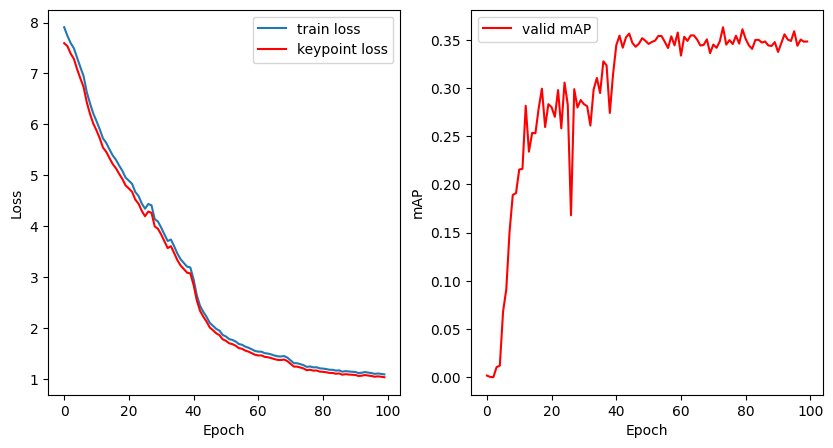

In [59]:
plt.figure(figsize = (10, 5))
plt.subplot(1, 2, 1)
plt.plot(range(stop), sc.file['train_loss_hist'], label = 'train loss')
plt.plot(range(stop), sc.file['keypoint_loss_hist'], label = 'keypoint loss', color = 'red')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(range(stop), sc.file['valid_map_hist'], label = 'valid mAP', color = 'red')
plt.xlabel('Epoch')
plt.ylabel('mAP')
plt.legend()
plt.show()

# 🔵 **Inference**

## 🔵 **Evaluate on Test**

In [60]:
model = torch.load('best_model.pt').eval()

In [61]:
valid_map = validation(model, test_loader, None, device)

|| mAP               = 0.35      ||    mAP|50     = 0.69    ||   mAP|75    =0.31  ||
|| mAP|small         = 0.087      ||    mAP|medium = 0.32    ||   mAP|large = 0.4 ||
|| mAR|1             = 0.32      ||    mAR|10     = 0.41    ||   mAR|100   = 0.41 ||
|| mAR|small         = 0.1      ||    mAR|medium = 0.37    ||   mAR|large = 0.47 ||
|| mAP|per_class     = -1.0      ||                         ||                    ||
|| mAR|100_per_class = -1.0      ||                         ||                    ||


## 🔵 **Visualize Function**

In [124]:
def show_random_samples(model, image_path, threshold):
  plt.figure(figsize = (10, 10 ))
  all_key_name = train_dataset.class_labels
  connection_rule = train_dataset.connect_law
  colors_list = train_dataset.colors
  connection_color = train_dataset.connection_color
  image = cv2.imread(image_path)
  image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
  plt.imshow(image)
  image = torch.tensor(image/255).permute(2, 0, 1).float()
  model.eval()
  with torch.no_grad():
    out = model([image.to(device)])[0]

  boxes = [out['boxes'][i] for i in range(out['boxes'].shape[0]) if out['scores'][i]>0.65]
  keypoints = [out['keypoints'][i] for i in range(out['boxes'].shape[0]) if out['scores'][i]>0.65]
  keypoints_scores = [out['keypoints_scores'][i] for i in range(out['boxes'].shape[0]) if out['scores'][i]>0.65]
  print(len(boxes))
  def visualize_out_model(boxes, keypoints, keypoints_scores):
    for box, keypoint, ks in zip(boxes, keypoints, keypoints_scores):
      j = keypoint.cpu()
      j = j.squeeze().numpy()
      ks = ks.cpu().squeeze().tolist()
      b = box
      joint = []
      cls_labels = []
      for i, (x, y, k) in enumerate(j):
        if k>0:
          if ks[i]>threshold:
            joint.append([x, y])
            cls_labels.append(all_key_name[i])
      j = np.array(joint)
      box = box.squeeze().tolist()
      key_name = cls_labels
      ax = plt.gca()
      rect = Rectangle((box[0] - 4, box[1] - 4),
                       (box[2] - box[0] + 4),
                       (box[3] - box[1] + 4),
                        fill = False,
                        edgecolor = (1, 0, 0),
                        linewidth = 2)
      ax.add_patch(rect)
      for key in key_name:
        plt.scatter(j[key_name.index(key), 0], j[key_name.index(key), 1], c = colors_list[all_key_name.index(key)], s = 20)

  visualize_out_model(boxes, keypoints, keypoints_scores)

## 🔵 **Visualize**

In [75]:
model = torch.load('best_model.pt').eval()

1


<ipython-input-116-98ffa883d0f5>:44: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  plt.scatter(j[key_name.index(key), 0], j[key_name.index(key), 1], c = colors_list[all_key_name.index(key)], s = 20)


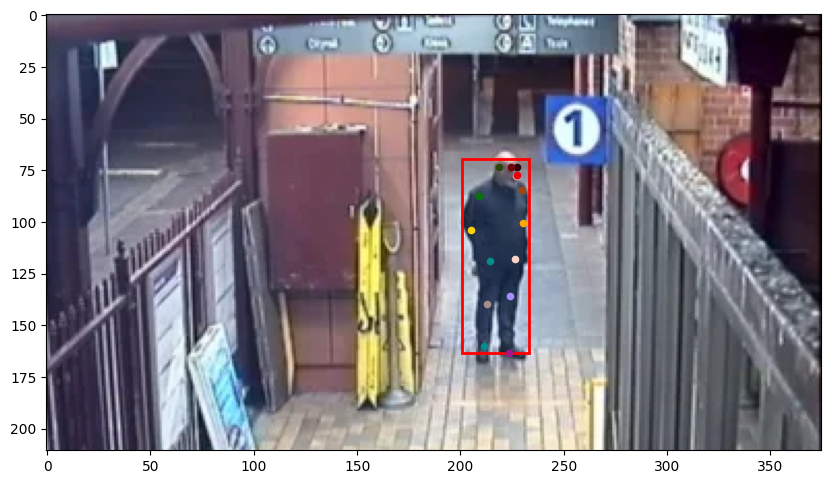

In [117]:
image_path = f'/content/Images/{test_im[100]}'
show_random_samples(model, image_path, 1.0)

1


<ipython-input-116-98ffa883d0f5>:44: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  plt.scatter(j[key_name.index(key), 0], j[key_name.index(key), 1], c = colors_list[all_key_name.index(key)], s = 20)


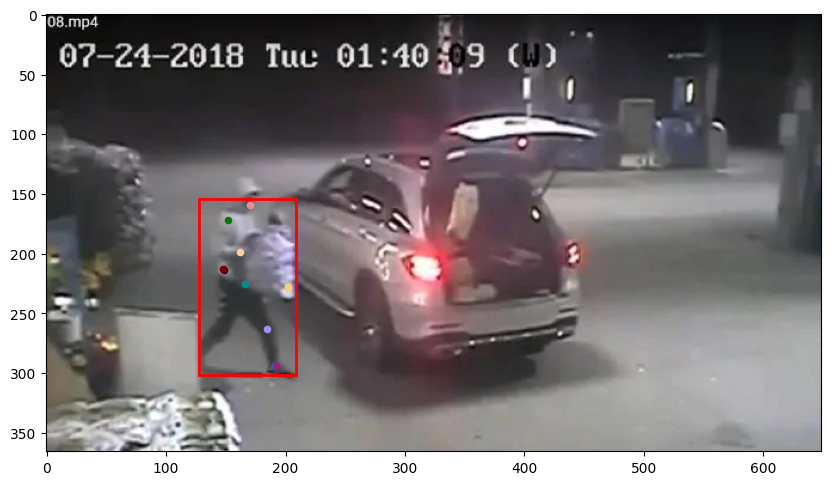

In [118]:
image_path = f'/content/Images/{test_im[10]}'
show_random_samples(model, image_path, 1.0)

1


<ipython-input-116-98ffa883d0f5>:44: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  plt.scatter(j[key_name.index(key), 0], j[key_name.index(key), 1], c = colors_list[all_key_name.index(key)], s = 20)


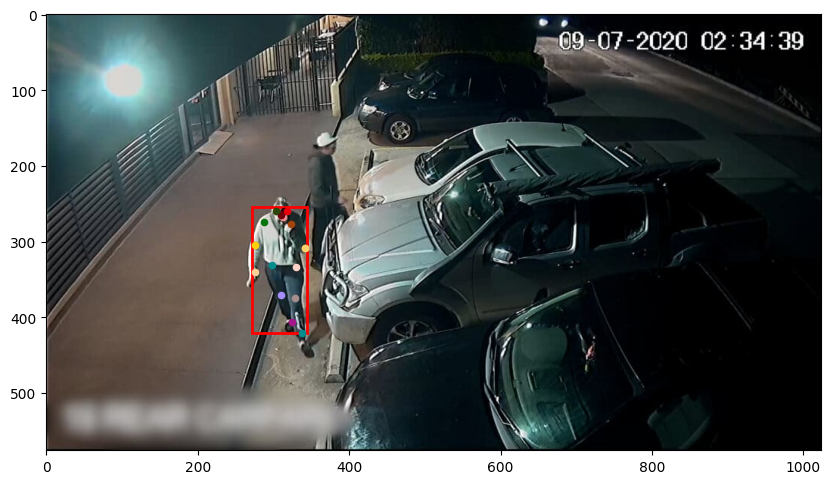

In [119]:
image_path = f'/content/Images/{test_im[2]}'
show_random_samples(model, image_path, 1.0)

3


<ipython-input-124-b7a0bb50b659>:44: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  plt.scatter(j[key_name.index(key), 0], j[key_name.index(key), 1], c = colors_list[all_key_name.index(key)], s = 20)


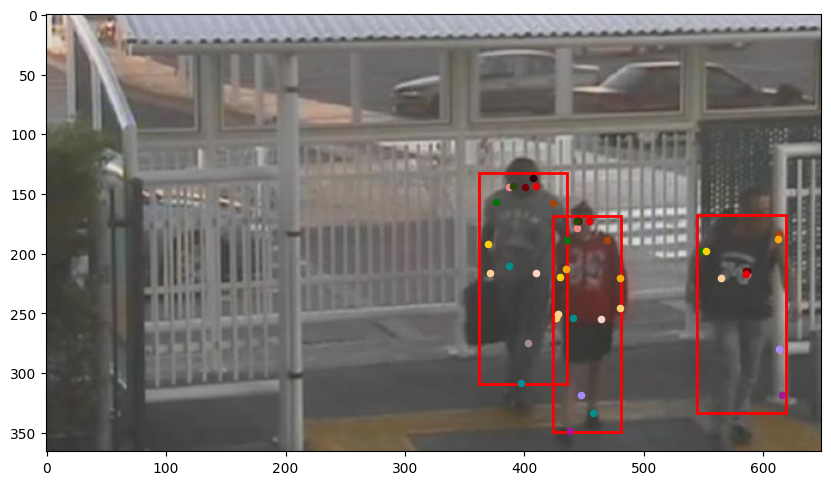

In [125]:
image_path = f'/content/Images/{test_im[70]}'
show_random_samples(model, image_path, 1.0)

1


<ipython-input-124-b7a0bb50b659>:44: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  plt.scatter(j[key_name.index(key), 0], j[key_name.index(key), 1], c = colors_list[all_key_name.index(key)], s = 20)


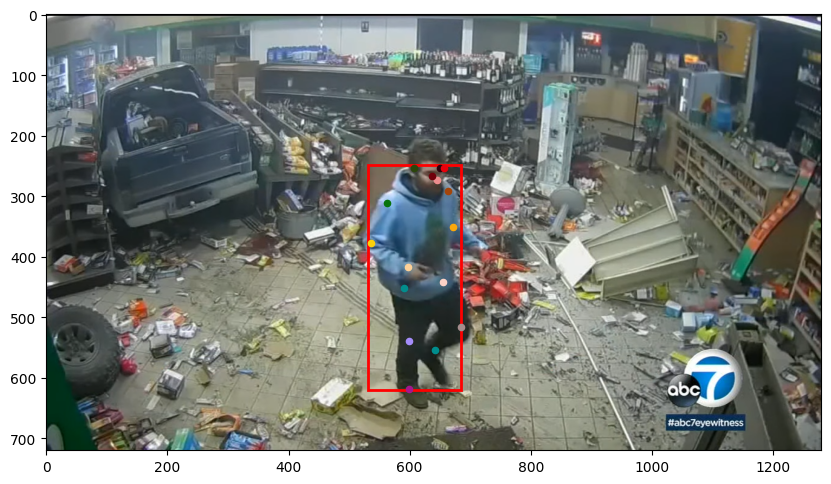

In [133]:
image_path = f'/content/Images/{test_im[99]}'
show_random_samples(model, image_path, 1.0)